# **Wind Speed Forecasting with Machine Learning**

This project develops a machine learning model for predicting wind speed (m/s) using diverse meteorological data collected from weather observation stations. To enhance the operation of wind power plants and improve energy production efficiency, observed weather features are utilized as input variables to build a precise wind speed prediction model. Various regression-based machine learning and AutoML techniques are applied to continuously improve model performance, and predictions are evaluated using Mean Absolute Error (MAE). The current focus is on building a data-driven wind speed prediction model applicable to real industrial settings and strengthening practical AI implementation capabilities.

### **Dataset Info.**

- ID: Unique identifier for each sample

- Month: Month when the data was recorded

- Day: Day when the data was recorded

- Time of Measurement: Time period of measurement (morning, afternoon, evening, or dawn)

- Celsius Temperature (°C): Ambient temperature in Celsius

- Absolute Temperature (K): Absolute temperature in Kelvin

- Dew Point Temperature (°C): Dew point temperature in Celsius

- Relative Humidity (%): Relative humidity as a percentage

- Atmospheric Pressure (mbar): Atmospheric pressure in millibars

- Saturation Vapor Pressure (mbar): Saturation vapor pressure in millibars

- Actual Vapor Pressure (mbar): Actual vapor pressure in millibars

- Vapor Pressure Deficit (mbar): Difference between saturation and actual vapor pressure (mbar)

- Water Vapor Content (g/kg): Mass of water vapor per kilogram of air

- Air Density (g/m³): Air mass per unit volume (grams per cubic meter)

- Wind Direction (deg): Wind direction in degrees

- Wind Speed (m/s): Wind speed in meters per second

In [32]:
# !pip install pycaret

In [33]:
# !pip install category_encoders

In [1]:
import numpy as np
import pandas as pd
import random
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pycaret.regression import setup, compare_models, tune_model, stack_models, finalize_model
import category_encoders

RANDOM_SEED = 42

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/DataAnalytics/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DataAnalytics/test.csv')

In [4]:
train.head()

,ID,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),풍속 (m/s)
0,TRAIN_00000,7,2,저녁,13.97,287.78,9.84,76.1,992.08,15.98,12.16,3.82,7.66,1198.06,155.60,1.61
1,TRAIN_00001,8,21,오전,16.94,290.85,12.14,73.3,991.07,19.33,14.17,5.16,8.94,1183.67,177.00,1.68
2,TRAIN_00002,11,1,저녁,9.76,283.84,5.40,74.2,988.71,12.10,8.98,3.12,5.67,1213.22,146.20,0.73
3,TRAIN_00003,12,28,오전,5.27,277.30,2.71,83.5,1014.25,8.89,7.43,1.47,4.57,1265.48,264.50,2.71
4,TRAIN_00004,9,26,오후,17.35,290.86,12.68,74.0,995.77,19.84,14.68,5.16,9.22,1187.40,19.34,1.00


In [5]:
test.head()

,ID,월,일,측정 시간대,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg)
0,TEST_00000,3,24,새벽,4.28,278.68,-0.21,72.5,984.48,8.30,6.02,2.28,3.81,1233.29,251.80
1,TEST_00001,9,24,저녁,13.40,286.81,10.36,81.8,996.98,15.40,12.59,2.80,7.89,1206.20,225.60
2,TEST_00002,5,28,저녁,19.89,294.33,14.95,73.2,984.83,23.26,17.03,6.23,10.82,1163.06,10.39
3,TEST_00003,1,17,저녁,-2.88,270.44,-4.47,88.7,998.02,4.94,4.38,0.56,2.73,1284.19,260.20
4,TEST_00004,10,22,오후,6.97,281.18,4.36,83.4,987.00,10.01,8.35,1.66,5.28,1223.47,262.50


## **Ⅰ. Preprocessing**


In [6]:
def preprocess_weather(df, is_test=False):
    columns = [
        'ID', 'Month', 'Day', 'TimeSlot', 'Temp_C', 'Temp_K', 'DewPoint', 'Humidity',
        'Pressure', 'SatVaporP', 'ActualVaporP', 'VaporShortage',
        'VaporContent', 'AirDensity', 'WindDir'
    ]
    if not is_test:
        columns += ['Velocity']
    df.columns = columns
    time_map = {'새벽': 0, '오전': 1, '오후': 2, '저녁': 3}
    df['TimeSlot'] = df['TimeSlot'].replace(time_map)
    df['Time_cos'] = np.cos(np.pi * df['TimeSlot'] / 2)
    df['Time_sin'] = np.sin(np.pi * df['TimeSlot'] / 2)
    df['WindDirCat'] = ((df['WindDir'] + 11.25) % 360 // 22.5).astype(int)
    df['WindDirX'] = np.cos(np.pi * df['WindDir'] / 180)
    df['WindDirY'] = np.sin(np.pi * df['WindDir'] / 180)
    df['Month_cos'] = np.cos((df['Month'] - 1) / 6 * np.pi)
    df['Month_sin'] = np.sin((df['Month'] - 1) / 6 * np.pi)
    drop_cols = ['ID', 'Temp_K', 'VaporContent']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    return df

df_train = preprocess_weather(train, is_test=False)
df_test = preprocess_weather(test, is_test=True)

In [7]:
df_train.head()

,Month,Day,TimeSlot,Temp_C,DewPoint,Humidity,Pressure,SatVaporP,ActualVaporP,VaporShortage,AirDensity,WindDir,Velocity,Time_cos,Time_sin,WindDirCat,WindDirX,WindDirY,Month_cos,Month_sin
0,7,2,3,13.97,9.84,76.1,992.08,15.98,12.16,3.82,1198.06,155.60,1.61,-1.836970e-16,-1.000000e+00,7,-0.910684,0.413104,-1.000000,1.224647e-16
1,8,21,1,16.94,12.14,73.3,991.07,19.33,14.17,5.16,1183.67,177.00,1.68,6.123234e-17,1.000000e+00,8,-0.998630,0.052336,-0.866025,-5.000000e-01
2,11,1,3,9.76,5.40,74.2,988.71,12.10,8.98,3.12,1213.22,146.20,0.73,-1.836970e-16,-1.000000e+00,6,-0.830984,0.556296,0.500000,-8.660254e-01
3,12,28,1,5.27,2.71,83.5,1014.25,8.89,7.43,1.47,1265.48,264.50,2.71,6.123234e-17,1.000000e+00,12,-0.095846,-0.995396,0.866025,-5.000000e-01
4,9,26,2,17.35,12.68,74.0,995.77,19.84,14.68,5.16,1187.40,19.34,1.00,-1.000000e+00,1.224647e-16,1,0.943570,0.331173,-0.500000,-8.660254e-01


In [8]:
df_test.head()

,Month,Day,TimeSlot,Temp_C,DewPoint,Humidity,Pressure,SatVaporP,ActualVaporP,VaporShortage,AirDensity,WindDir,Time_cos,Time_sin,WindDirCat,WindDirX,WindDirY,Month_cos,Month_sin
0,3,24,0,4.28,-0.21,72.5,984.48,8.30,6.02,2.28,1233.29,251.80,1.000000e+00,0.000000e+00,11,-0.312335,-0.949972,5.000000e-01,0.866025
1,9,24,3,13.40,10.36,81.8,996.98,15.40,12.59,2.80,1206.20,225.60,-1.836970e-16,-1.000000e+00,10,-0.699663,-0.714473,-5.000000e-01,-0.866025
2,5,28,3,19.89,14.95,73.2,984.83,23.26,17.03,6.23,1163.06,10.39,-1.836970e-16,-1.000000e+00,0,0.983603,0.180347,-5.000000e-01,0.866025
3,1,17,3,-2.88,-4.47,88.7,998.02,4.94,4.38,0.56,1284.19,260.20,-1.836970e-16,-1.000000e+00,12,-0.170209,-0.985408,1.000000e+00,0.000000
4,10,22,2,6.97,4.36,83.4,987.00,10.01,8.35,1.66,1223.47,262.50,-1.000000e+00,1.224647e-16,12,-0.130526,-0.991445,-1.836970e-16,-1.000000


## **Ⅱ. Exploratory Data Analysis**

In [9]:
df_train.isna().sum()

,0
Month,0
Day,0
TimeSlot,0
Temp_C,0
DewPoint,0
Humidity,0
Pressure,0
SatVaporP,0
ActualVaporP,0
VaporShortage,0


In [10]:
train.describe()

,Month,Day,TimeSlot,Temp_C,Temp_K,DewPoint,Humidity,Pressure,SatVaporP,ActualVaporP,...,AirDensity,WindDir,Velocity,Time_cos,Time_sin,WindDirCat,WindDirX,WindDirY,Month_cos,Month_sin
count,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,36581.000000,...,36581.000000,36581.00000,36581.000000,3.658100e+04,3.658100e+04,36581.000000,36581.000000,36581.000000,3.658100e+04,36581.000000
mean,6.511468,15.648561,1.502009,9.992694,283.971095,5.453064,75.827418,990.032953,14.037167,9.786895,...,1214.580682,176.58240,2.036446,-1.694869e-03,-8.200979e-05,7.672480,-0.311126,-0.166860,-9.816289e-04,0.000004
std,3.458678,8.803467,1.117326,8.237177,8.354235,6.327009,16.089188,8.824477,8.075680,4.185701,...,39.528520,84.38269,1.544146,7.069501e-01,7.072807e-01,3.753551,0.688498,0.633524,7.113461e-01,0.702861
min,1.000000,1.000000,0.000000,-13.930000,258.870000,-15.560000,23.640000,956.890000,2.070000,1.810000,...,1110.650000,0.01000,0.100000,-1.000000e+00,-1.000000e+00,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000
25%,4.000000,8.000000,1.000000,3.650000,277.700000,0.450000,65.360000,985.100000,7.940000,6.310000,...,1184.030000,129.40000,0.920000,-1.000000e+00,-1.000000e+00,5.000000,-0.893371,-0.739631,-8.660254e-01,-0.500000
50%,7.000000,16.000000,2.000000,9.130000,283.170000,5.070000,79.000000,990.250000,11.590000,8.770000,...,1214.650000,199.50000,1.630000,-1.836970e-16,1.224647e-16,9.000000,-0.600420,-0.294040,6.123234e-17,0.000000
75%,9.000000,23.000000,3.000000,16.350000,290.370000,10.950000,89.200000,995.700000,18.620000,13.100000,...,1241.600000,233.90000,2.700000,6.123234e-17,1.000000e+00,10.000000,0.228351,0.420719,8.660254e-01,0.500000
max,12.000000,31.000000,3.000000,34.340000,308.620000,20.150000,100.000000,1015.300000,54.270000,23.640000,...,1349.460000,360.00000,11.890000,1.000000e+00,1.000000e+00,15.000000,1.000000,1.000000,1.000000e+00,1.000000


In [11]:
train.head()

,ID,Month,Day,TimeSlot,Temp_C,Temp_K,DewPoint,Humidity,Pressure,SatVaporP,...,AirDensity,WindDir,Velocity,Time_cos,Time_sin,WindDirCat,WindDirX,WindDirY,Month_cos,Month_sin
0,TRAIN_00000,7,2,3,13.97,287.78,9.84,76.1,992.08,15.98,...,1198.06,155.60,1.61,-1.836970e-16,-1.000000e+00,7,-0.910684,0.413104,-1.000000,1.224647e-16
1,TRAIN_00001,8,21,1,16.94,290.85,12.14,73.3,991.07,19.33,...,1183.67,177.00,1.68,6.123234e-17,1.000000e+00,8,-0.998630,0.052336,-0.866025,-5.000000e-01
2,TRAIN_00002,11,1,3,9.76,283.84,5.40,74.2,988.71,12.10,...,1213.22,146.20,0.73,-1.836970e-16,-1.000000e+00,6,-0.830984,0.556296,0.500000,-8.660254e-01
3,TRAIN_00003,12,28,1,5.27,277.30,2.71,83.5,1014.25,8.89,...,1265.48,264.50,2.71,6.123234e-17,1.000000e+00,12,-0.095846,-0.995396,0.866025,-5.000000e-01
4,TRAIN_00004,9,26,2,17.35,290.86,12.68,74.0,995.77,19.84,...,1187.40,19.34,1.00,-1.000000e+00,1.224647e-16,1,0.943570,0.331173,-0.500000,-8.660254e-01


In [12]:
test.head()

,ID,Month,Day,TimeSlot,Temp_C,Temp_K,DewPoint,Humidity,Pressure,SatVaporP,...,VaporContent,AirDensity,WindDir,Time_cos,Time_sin,WindDirCat,WindDirX,WindDirY,Month_cos,Month_sin
0,TEST_00000,3,24,0,4.28,278.68,-0.21,72.5,984.48,8.30,...,3.81,1233.29,251.80,1.000000e+00,0.000000e+00,11,-0.312335,-0.949972,5.000000e-01,0.866025
1,TEST_00001,9,24,3,13.40,286.81,10.36,81.8,996.98,15.40,...,7.89,1206.20,225.60,-1.836970e-16,-1.000000e+00,10,-0.699663,-0.714473,-5.000000e-01,-0.866025
2,TEST_00002,5,28,3,19.89,294.33,14.95,73.2,984.83,23.26,...,10.82,1163.06,10.39,-1.836970e-16,-1.000000e+00,0,0.983603,0.180347,-5.000000e-01,0.866025
3,TEST_00003,1,17,3,-2.88,270.44,-4.47,88.7,998.02,4.94,...,2.73,1284.19,260.20,-1.836970e-16,-1.000000e+00,12,-0.170209,-0.985408,1.000000e+00,0.000000
4,TEST_00004,10,22,2,6.97,281.18,4.36,83.4,987.00,10.01,...,5.28,1223.47,262.50,-1.000000e+00,1.224647e-16,12,-0.130526,-0.991445,-1.836970e-16,-1.000000


In [13]:
train.columns

Index(['ID', 'Month', 'Day', 'TimeSlot', 'Temp_C', 'Temp_K', 'DewPoint',
       'Humidity', 'Pressure', 'SatVaporP', 'ActualVaporP', 'VaporShortage',
       'VaporContent', 'AirDensity', 'WindDir', 'Velocity', 'Time_cos',
       'Time_sin', 'WindDirCat', 'WindDirX', 'WindDirY', 'Month_cos',
       'Month_sin'],
      dtype='object')

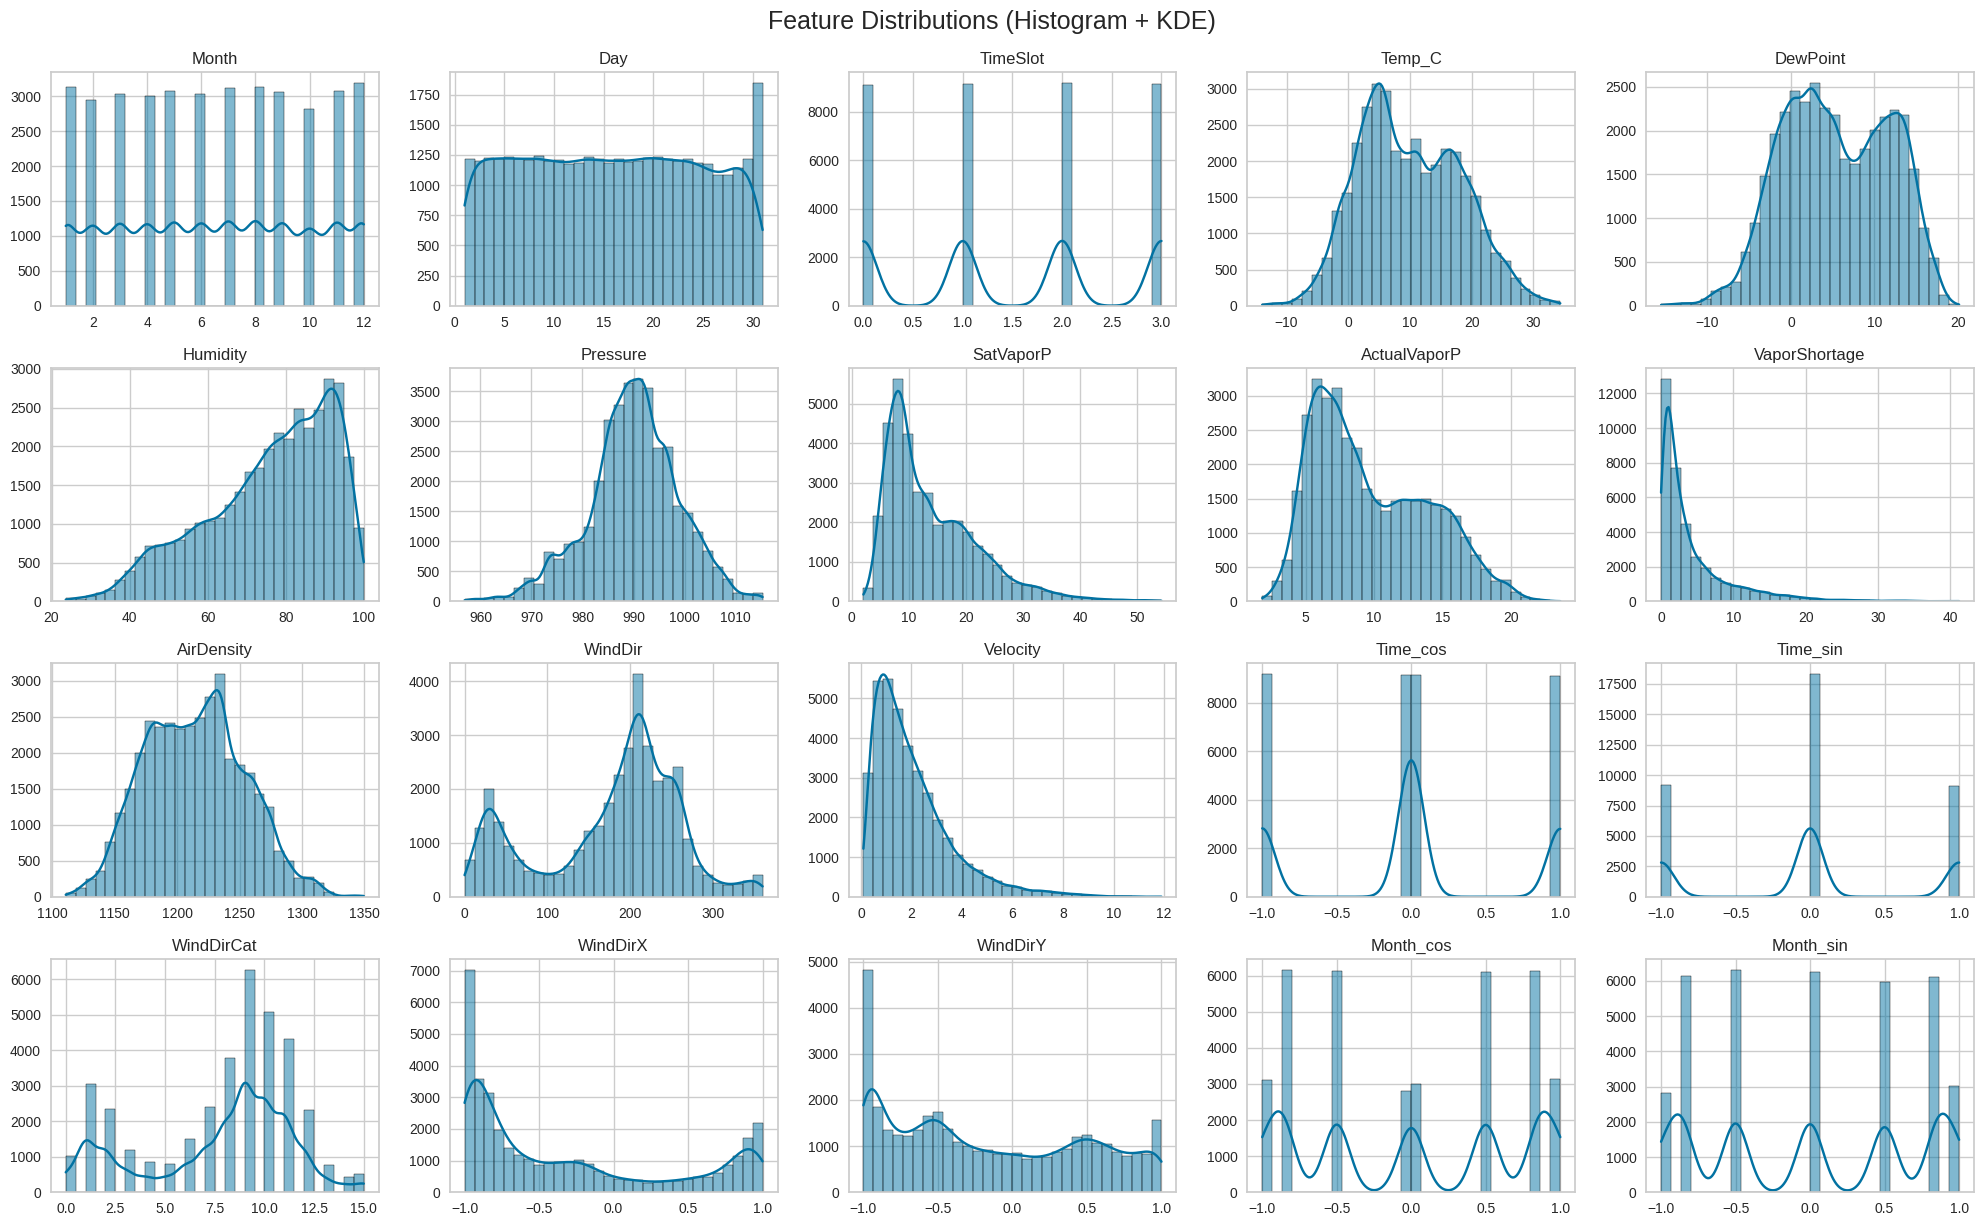

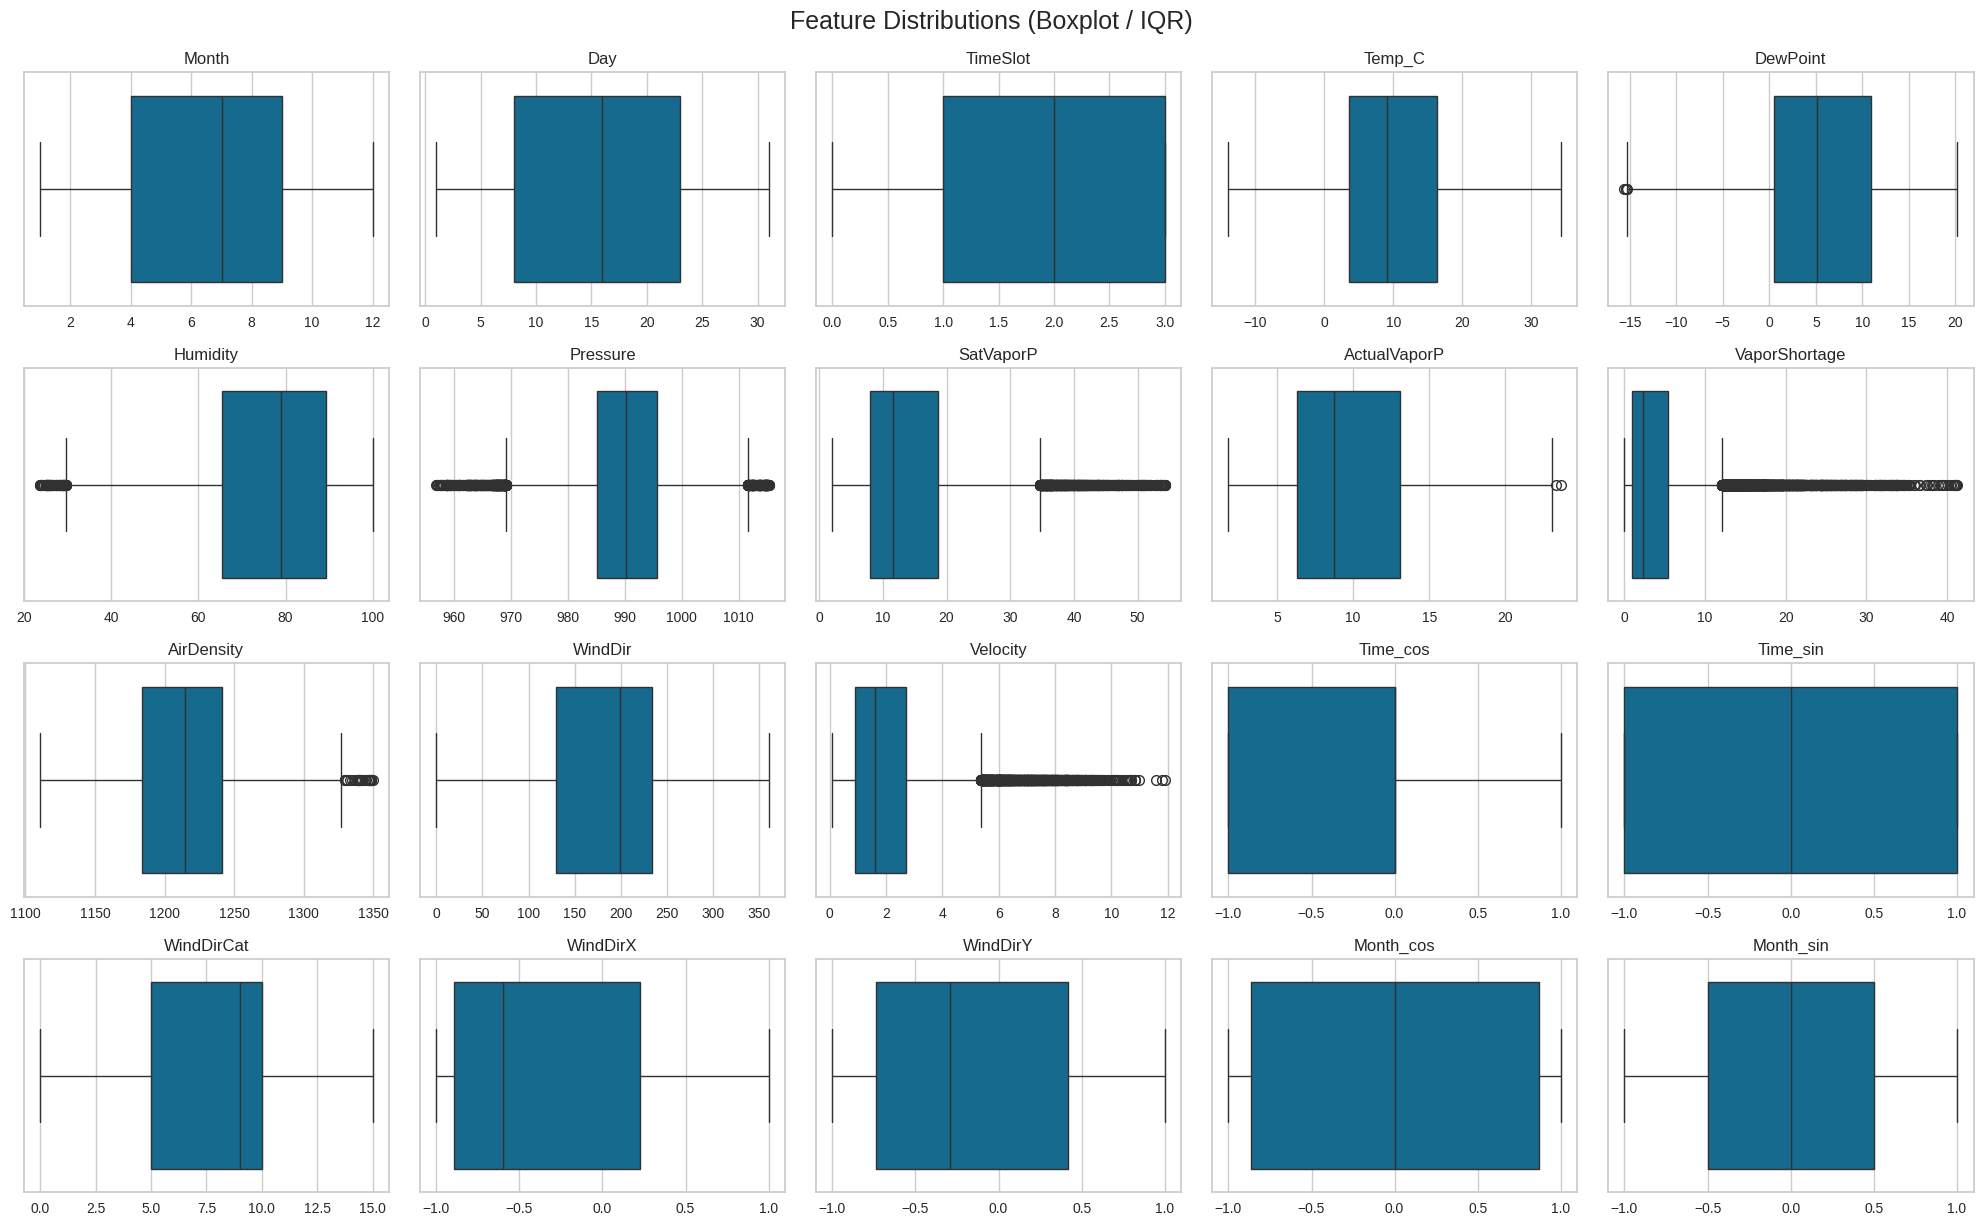

In [14]:
features = list(df_train.columns)

# 1. Feature Distributions (Histogram + KDE)
n_cols = 5
n_rows = int(np.ceil(len(features) / n_cols))
plt.figure(figsize=(n_cols*4, n_rows*3))

for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df_train[col], kde=True, bins=30)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.suptitle('Feature Distributions (Histogram + KDE)', fontsize=18, y=1.02)
plt.show()

# 2. Feature Distributions (Boxplot / IQR)
plt.figure(figsize=(n_cols*4, n_rows*3))

for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x=df_train[col])
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.suptitle('Feature Distributions (Boxplot / IQR)', fontsize=18, y=1.02)
plt.show()

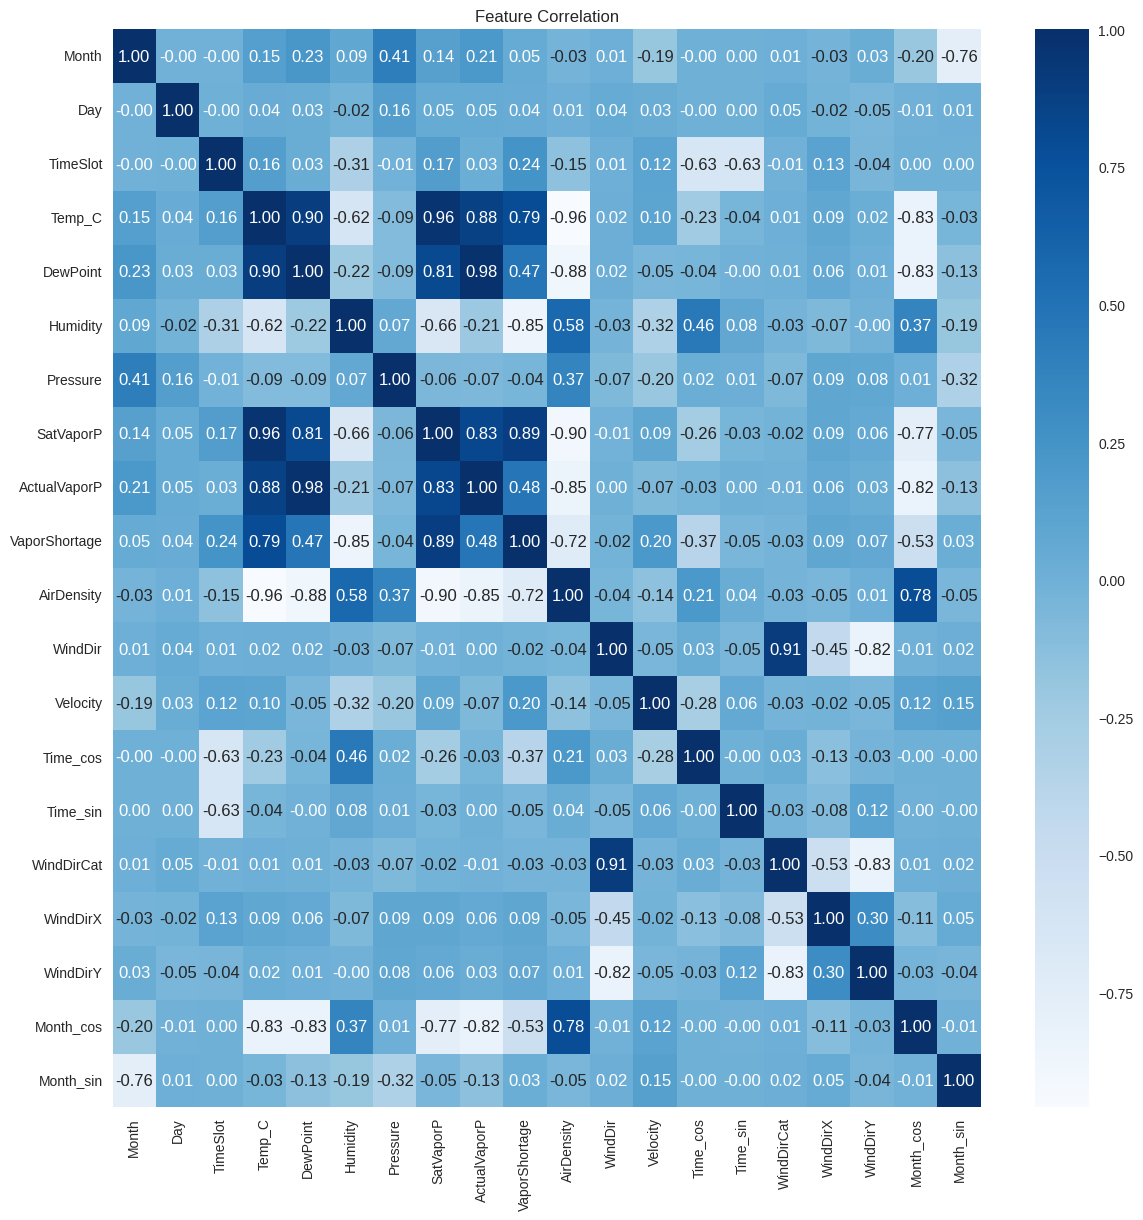

In [15]:
corr = df_train.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Feature Correlation')
plt.show()

**Top 10 features by absolute correlation with Velocity**

In [41]:
target = 'Velocity'
corrs = df_train.corr()[target].drop(target)
top_corrs = corrs.abs().sort_values(ascending=False).head(10)
print("Top 10 features by absolute correlation with Velocity:\n")
print(f"{'Feature':<18} {'  Abs(Corr)':>12} {'Corr':>12}")
print("-"*44)
for feat in top_corrs.index:
    print(f"{feat:<18} | {top_corrs[feat]:>10.4f} | {corrs[feat]:>10.4f}")

Top 10 features by absolute correlation with Velocity:

Feature               Abs(Corr)         Corr
--------------------------------------------
Humidity           |     0.3211 |    -0.3211
Time_cos           |     0.2830 |    -0.2830
VaporShortage      |     0.2050 |     0.2050
Dist_1             |     0.2034 |     0.2034
Pressure           |     0.2003 |    -0.2003
Month              |     0.1865 |    -0.1865
Month_sin          |     0.1462 |     0.1462
AirDensity         |     0.1406 |    -0.1406
Month_cos          |     0.1237 |     0.1237
TimeSlot           |     0.1166 |     0.1166


**Feature Importance**

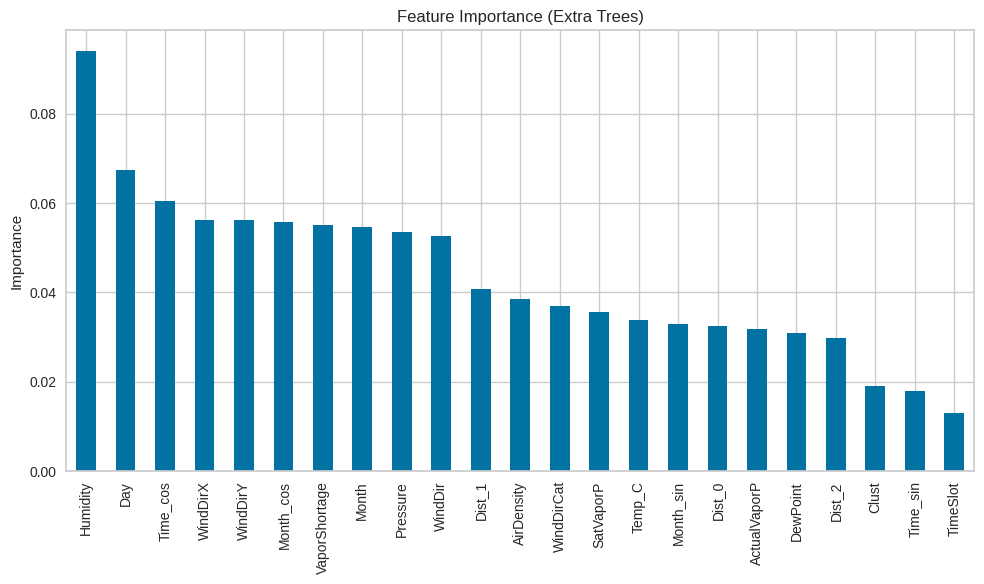

Top features:

Humidity         0.093914
Day              0.067294
Time_cos         0.060355
WindDirX         0.056217
WindDirY         0.056200
Month_cos        0.055808
VaporShortage    0.055103
Month            0.054749
Pressure         0.053610
WindDir          0.052738
dtype: float64


In [40]:
X = df_train.drop('Velocity', axis=1)
y = df_train['Velocity']
forest = ExtraTreesRegressor(n_estimators=100, random_state=42)
forest.fit(X, y)
feat_importance = pd.Series(forest.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importance.plot(kind='bar')
plt.title('Feature Importance (Extra Trees)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print("Top features:\n")
print(feat_importance.head(10))
top_features = feat_importance.head(8).index.tolist()

In [34]:
# Top 10 by correlation coefficient
top_corr_feats = df_train.corr()['Velocity'].abs().sort_values(ascending=False).drop('Velocity').head(10).index.tolist()
print("Top 10 by correlation coefficient", top_corr_feats)

# Feature importance top 10
top_imp_feats = feat_importance.head(10).index.tolist()
print("feature importance top 10", top_imp_feats)

# Features with both high correlation and high importance
final_outlier_feats_inter = list(set(top_corr_feats) & set(top_imp_feats))
print("Features with both high correlation and high importance:", final_outlier_feats_inter)

Top 10 by correlation coefficient ['Humidity', 'Time_cos', 'VaporShortage', 'Dist_1', 'Pressure', 'Month', 'Month_sin', 'AirDensity', 'Month_cos', 'TimeSlot']
feature importance top 10 ['Humidity', 'Pressure', 'Day', 'VaporShortage', 'WindDirX', 'Month_cos', 'Time_cos', 'WindDirY', 'WindDir', 'Month']
Features with both high correlation and high importance: ['Time_cos', 'Pressure', 'Humidity', 'VaporShortage', 'Month_cos', 'Month']


In [19]:
def remove_outliers(df, cols, k=1.5):
    for col in cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        low, high = q1 - k*iqr, q3 + k*iqr
        df = df[(df[col] >= low) & (df[col] <= high)]
    return df

important_feats = final_outlier_feats_inter

df_train = remove_outliers(df_train, important_feats)
print("Shape after outlier removal:", df_train.shape)

Shape after outlier removal: (32711, 20)


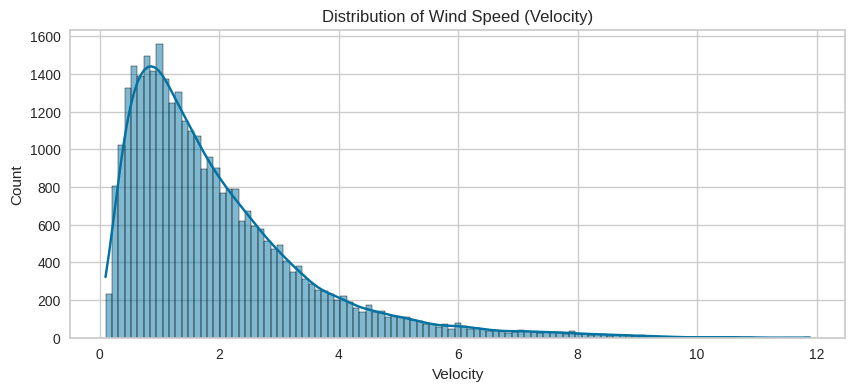

In [20]:
plt.figure(figsize=(10,4))
sns.histplot(df_train['Velocity'], kde=True)
plt.title('Distribution of Wind Speed (Velocity)')
plt.show()

## **Ⅲ. Modeling & Validation**

In [22]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=X.columns)

# KMeans clustering
cluster_feats = ['Month_cos', 'Month_sin', 'Temp_C', 'Pressure', 'VaporShortage', 'WindDirX', 'WindDirY']

for col in cluster_feats:
    X_scaled[col] = X_scaled[col].astype(np.float64)
    df_test_scaled[col] = df_test_scaled[col].astype(np.float64)
kmeans = KMeans(n_clusters=6, random_state=42)
X_scaled['Clust'] = kmeans.fit_predict(X_scaled[cluster_feats])
df_test_scaled['Clust'] = kmeans.predict(df_test_scaled[cluster_feats])
for n in range(3):
    X_scaled[f'Dist_{n}'] = kmeans.transform(X_scaled[cluster_feats])[:, n]
    df_test_scaled[f'Dist_{n}'] = kmeans.transform(df_test_scaled[cluster_feats])[:, n]

#### **(1) Extra Trees Regressor**

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
et_model = ExtraTreesRegressor(n_estimators=200, random_state=42)
et_model.fit(X_train, y_train)
et_pred = et_model.predict(X_val)
et_mae = mean_absolute_error(y_val, et_pred)
et_r2 = r2_score(y_val, et_pred)
print(f'Extra Trees: MAE={et_mae:.4f}, R2={et_r2:.4f}')

Extra Trees: MAE=0.4163, R2=0.8721


#### **(2) Ensemble with Top Features**

In [24]:
X_top = X_scaled[top_features + ['Clust', 'Dist_0', 'Dist_1', 'Dist_2']]
df_test_top = df_test_scaled[top_features + ['Clust', 'Dist_0', 'Dist_1', 'Dist_2']]
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_top, y, test_size=0.2, random_state=42)

base_learners = [
    ('et', ExtraTreesRegressor(n_estimators=150, random_state=1)),
    ('rf', RandomForestRegressor(n_estimators=150, random_state=2)),
    ('gbr', GradientBoostingRegressor(n_estimators=120, random_state=3)),
    ('ridge', Ridge(alpha=2.0, random_state=4)),
    ('lasso', Lasso(alpha=0.01, random_state=5)),
    ('lr', LinearRegression())
]
ensemble_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)
ensemble_model.fit(X_train2, y_train2)
ensemble_pred = ensemble_model.predict(X_val2)
ensemble_mae = mean_absolute_error(y_val2, ensemble_pred)
ensemble_r2 = r2_score(y_val2, ensemble_pred)
print(f'Ensemble(Stacking): MAE={ensemble_mae:.4f}, R2={ensemble_r2:.4f}')

Ensemble(Stacking): MAE=0.4381, R2=0.8560


In [25]:
if ensemble_mae < et_mae:
    best = "Ensemble"
    best_model = ensemble_model
    best_feats = X_top
    best_test = df_test_top
    print("Using Stacking Ensemble (best MAE).")
else:
    best = "ExtraTrees"
    best_model = et_model
    best_feats = X_scaled
    best_test = df_test_scaled
    print("Using Extra Trees Regressor (best MAE).")

cv_mae = -cross_val_score(best_model, best_feats, y, cv=5, scoring='neg_mean_absolute_error')
print(f'{best} Model CV MAE (5-fold): {cv_mae.mean():.4f} ± {cv_mae.std():.4f}')

best_model.fit(best_feats, y)
y_test_pred = best_model.predict(best_test)

Using Extra Trees Regressor (best MAE).
ExtraTrees Model CV MAE (5-fold): 0.4114 ± 0.0050


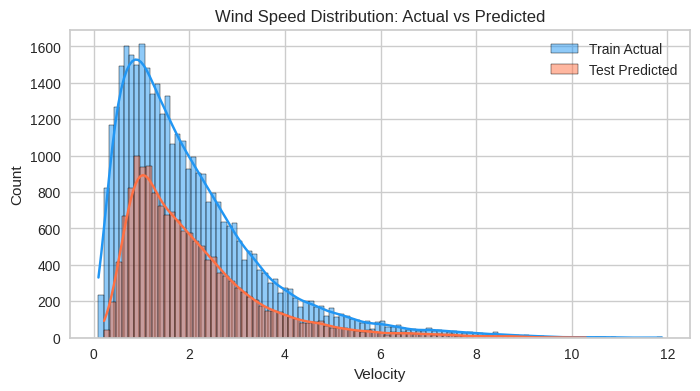

In [26]:
plt.figure(figsize=(8,4))
sns.histplot(y, color='#2196F3', label='Train Actual', kde=True)
sns.histplot(y_test_pred, color='#FF7043', label='Test Predicted', kde=True)
plt.title('Wind Speed Distribution: Actual vs Predicted')
plt.legend()
plt.show()

Although the quantitative metrics—R² of approximately 0.87 and MAE of 0.41—indicate solid overall performance, we further evaluated the model by visually comparing the distributions of the predicted and actual values, thereby assessing not only the general accuracy but also the segment-wise performance.
While the predicted distribution closely resembled the actual distribution in general, the actual values were more concentrated in the lower wind speed range, and the predicted distribution appeared broader and less peaked. Notably, in the high wind speed region, the model tended to predict fewer cases than were observed in reality.

In [36]:
submission = pd.read_csv('/content/drive/MyDrive/DataAnalytics/sample_submission.csv')
submission['Wind Speed (m/s)'] = y_test_pred
submission.to_csv('/content/drive/MyDrive/DataAnalytics/submission.csv', index=False)
result = pd.read_csv('/content/drive/MyDrive/DataAnalytics/submission.csv')
result

,ID,Wind Speed (m/s)
0,TEST_00000,2.05565
1,TEST_00001,1.08460
2,TEST_00002,2.12605
3,TEST_00003,1.09565
4,TEST_00004,1.25685
...,...,...
15673,TEST_15673,4.17760
15674,TEST_15674,1.88575
15675,TEST_15675,1.22485
15676,TEST_15676,1.98570


## **Ⅳ. PyCaret**

In [28]:
train_raw = pd.read_csv('/content/drive/MyDrive/DataAnalytics/train.csv')
test_raw = pd.read_csv('/content/drive/MyDrive/DataAnalytics/test.csv')
df_train = preprocess_weather(train_raw, is_test=False)
df_test = preprocess_weather(test_raw, is_test=True)

In [29]:
from sklearn.cluster import KMeans

cluster_feats = ['Month_cos', 'Month_sin', 'Temp_C', 'Pressure', 'VaporShortage', 'WindDirX', 'WindDirY']

for col in cluster_feats:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce').astype(np.float64)
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce').astype(np.float64)

kmeans = KMeans(n_clusters=3, random_state=42)
df_train['Clust'] = kmeans.fit_predict(df_train[cluster_feats])
df_test['Clust'] = kmeans.predict(df_test[cluster_feats])
for n in range(3):
    df_train[f'Dist_{n}'] = kmeans.transform(df_train[cluster_feats])[:, n]
    df_test[f'Dist_{n}'] = kmeans.transform(df_test[cluster_feats])[:, n]

In [30]:
class SuppressStdoutStderr(object):
    def __enter__(self):
        self._stdout = sys.stdout
        self._stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._stdout
        sys.stderr = self._stderr

with SuppressStdoutStderr():
    reg = setup(
        data=df_train,
        target='Velocity',
        ignore_features=['WindDirX', 'WindDirY'],
        use_gpu=True,
        session_id=42,
        encoding_method=category_encoders.target_encoder.TargetEncoder(smoothing=10),
        max_encoding_ohe=1,
    )

    top_models = compare_models(n_select=4)
    for idx in [2, 3]:
        top_models[idx] = tune_model(top_models[idx], optimize='MAE', n_iter=100)

    stacked = stack_models(top_models, optimize='MAE', choose_better=True)
    final_model = finalize_model(stacked)

,Description,Value
0,Session id,42
1,Target,Velocity
2,Target type,Regression
3,Original data shape,"(36581, 24)"
4,Transformed data shape,"(36581, 22)"
5,Transformed train set shape,"(25606, 22)"
6,Transformed test set shape,"(10975, 22)"
7,Ignore features,2
8,Numeric features,21
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.4146,0.3301,0.5742,0.8600,0.1940,0.3460,1.7900
rf,Random Forest Regressor,0.4831,0.4273,0.6535,0.8186,0.2213,0.4248,0.9810
xgboost,Extreme Gradient Boosting,0.5248,0.4989,0.7061,0.7883,0.2389,0.4365,0.3000
lightgbm,Light Gradient Boosting Machine,0.5941,0.6177,0.7857,0.7379,0.2624,0.5125,1.1010
knn,K Neighbors Regressor,0.5853,0.6700,0.8184,0.7156,0.2768,0.5349,0.0670
dt,Decision Tree Regressor,0.6135,0.8276,0.9094,0.6480,0.2952,0.4774,0.6220
gbr,Gradient Boosting Regressor,0.7747,1.0528,1.0258,0.5533,0.3263,0.6711,10.5470
ridge,Ridge Regression,0.9750,1.6965,1.3024,0.2799,0.3968,0.8324,0.0330
br,Bayesian Ridge,0.9750,1.6965,1.3024,0.2799,0.3969,0.8324,0.1170
lr,Linear Regression,0.9777,1.7038,1.3051,0.2769,0.3978,0.8355,0.1320


Processing:   0%|          | 0/84 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4570,0.3876,0.6226,0.8442,0.2072,0.3794
1,0.4306,0.3393,0.5825,0.8482,0.1993,0.3594
2,0.4521,0.3850,0.6205,0.8332,0.2097,0.3734
3,0.4555,0.3709,0.6090,0.8354,0.2147,0.4104
4,0.4572,0.3959,0.6292,0.8304,0.2104,0.3837
5,0.4645,0.4067,0.6377,0.8393,0.2108,0.3870
6,0.4514,0.3683,0.6069,0.8398,0.2070,0.3742
7,0.4421,0.3568,0.5974,0.8436,0.2062,0.3727
8,0.4467,0.3720,0.6099,0.8427,0.2066,0.3653


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5045,0.4742,0.6886,0.8094,0.2266,0.4065
1,0.4729,0.4068,0.6378,0.8179,0.2173,0.3912
2,0.4989,0.4612,0.6791,0.8002,0.2284,0.4037
3,0.5066,0.4567,0.6758,0.7974,0.2354,0.4472
4,0.5090,0.4840,0.6957,0.7927,0.2337,0.4170
5,0.5063,0.4697,0.6854,0.8143,0.2268,0.4098
6,0.4875,0.4340,0.6588,0.8112,0.2243,0.3942
7,0.4754,0.4129,0.6426,0.8191,0.2225,0.3980
8,0.4943,0.4468,0.6684,0.8111,0.2255,0.3981


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4126,0.3256,0.5706,0.8691,0.1880,0.3212
1,0.3856,0.2764,0.5258,0.8763,0.1811,0.3080
2,0.4091,0.3332,0.5772,0.8557,0.1917,0.3216
3,0.4154,0.3120,0.5585,0.8616,0.1977,0.3547
4,0.4085,0.3280,0.5727,0.8595,0.1908,0.3243
5,0.4198,0.3522,0.5935,0.8608,0.1916,0.3242
6,0.4082,0.3162,0.5623,0.8625,0.1873,0.3129
7,0.4023,0.3067,0.5538,0.8656,0.1896,0.3206
8,0.4012,0.3127,0.5592,0.8678,0.1893,0.3166


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
df_test_input = df_test.drop(['WindDirX', 'WindDirY'], axis=1)
submission = pd.read_csv('/content/drive/MyDrive/DataAnalytics/sample_submission.csv')
submission['Wind Speed (m/s)'] = final_model.predict(df_test_input)
submission.to_csv('/content/drive/MyDrive/DataAnalytics/submission.csv', index=False)
result_AML = pd.read_csv('/content/drive/MyDrive/DataAnalytics/submission.csv')
result_AML

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4


,ID,Wind Speed (m/s)
0,TEST_00000,1.636476
1,TEST_00001,1.020963
2,TEST_00002,2.074687
3,TEST_00003,1.076704
4,TEST_00004,1.130160
...,...,...
15673,TEST_15673,4.482144
15674,TEST_15674,1.934217
15675,TEST_15675,1.137222
15676,TEST_15676,2.021398


## **Ⅴ. Results & Analysis**

In this project, we compared a manual feature-driven machine learning approach with PyCaret AutoML for wind speed prediction.

**1. Feature-driven ML (Manual Process)**

- Process: Unnecessary variables were removed, and only the most relevant features (based on correlation and importance) were used. KMeans-based clustering features and outlier removal (IQR) were included, along with derived features for wind direction and meteorological periodicity, to maximize pattern extraction from the data.

- Model Performance:

  - Extra Trees Regressor (5-fold CV):

  - MAE: 0.4114 ± 0.0050

  - R²: 0.8721

- Single Extra Trees on validation: MAE=0.4163, R²=0.8721

- Notes:

  - High model interpretability and robust generalization

  - Consistent results across folds, indicating model stability

**2. PyCaret**

- Process: PyCaret's automated pipeline handled encoding, normalization, model comparison, hyperparameter tuning, and ensembling without manual feature engineering.

- Model Performance:

  - Extra Trees Regressor (5-fold CV):

  - MAE: 0.4146

  - R²: 0.8600

- Notes:

  - Slightly higher MAE compared to manual, but the difference is negligible

  - Superior for rapid prototyping, reproducibility, and broad model exploration

**3. Objective Comparison & Insights**

- Both approaches achieved nearly identical accuracy, with MAE 0.41-0.42 and R² 0.86-0.88

- Manual approach offers better feature interpretability and data-driven decision-making, while AutoML excels in productivity and experiment diversity

- Fine-grained preprocessing such as clustering and outlier removal improved both generalization and predictive accuracy

- Real test set predictions showed minimal difference, with both approaches suitable for practical deployment

**Conclusion**

For wind speed prediction, both a carefully preprocessed, feature-driven ML pipeline and an automated workflow achieved comparable predictive power. In practice, combining domain-informed modeling with AutoML can balance interpretability, productivity, and reproducibility, making both approaches valuable tools for industrial applications.